# One File With All Code of Every Milestone 

This file contains the optimal models that were obtained at the end of every milestone.

The code in this file was written by Brian Jakobs, Vera Eising, Joram Brokkelkamp and Damla Baspinar, with the purpose of making a first model for the Machine Learning Project Pawpularity in the Minor Artificial Intelligence at the University of Amsterdam.
This code was last modified at the 6th of February, 2022. 

## Import libraries for functions

In [ ]:
# Import the needed libraries
import os, random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Tensorflow 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, preprocessing, regularizers

# Google.colab drive import for image data
from google.colab import drive

# Make sure the most recent versions of libraries are imported
%load_ext autoreload 
%autoreload 2 

# Import the data
Get the tabular data from github and the images from google.drive or drive of computer

In [ ]:
# Data from github
url = 'https://raw.githubusercontent.com/Veer56/Pawl_patrol/main/Code/data/train.csv'
train_data = pd.read_csv(url)

# Check for any Nan values in the train data, to find any missing values
train_data.isnull().values.any()

# Display an example of the tabular data
display(train_data.head(5))

# prompt for file location
print("How would you like to open the image data file?")
choice = int(input("To open the file via google drive enter '1', to open the file via a folder on your PC enter '2'. \n"))

# prompt for google drive path
if choice == 1:

    path = '/content/gdrive'
    drive.mount(path)

    drive_path = input("Please specify the path to your petfinder-pawpularity-score.zip file. \n")

    # unzip the file from the google drive
    !unzip -q "$drive_path"

# prompt for PC path
if choice == 2:
    pc_path = input("Please specify the path to the folder on your PC containing the train folder. \n")
    os.chdir(pc_path)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


How would you like to open the image data file?
To open the file via google drive enter '1', to open the file via a folder on your PC enter '2'. 
1
Mounted at /content/gdrive
Please specify the path to your petfinder-pawpularity-score.zip file. 
/content/gdrive/MyDrive/Data/petfinder-pawpularity-score.zip


## Import external files from Github

In [ ]:
# Prompt the user for the environment
print("Are you working in Jupyter Notebook or on Google Colab?")
answer = int(input("If you are working in Jupyter Notebook enter '1', if you are working in Google Colab enter '2'. \n"))

# Import the external files in a Jupyter Notebook
if answer == 1:
  %load https://raw.githubusercontent.com/Veer56/Pawl_patrol/main/Code/class_train_and_evaluate.py
  import class_train_and_evaluate 

# Import the external files in Google Colab
if answer == 2:
  %rm -rf Pawl_patrol
  !git clone https://github.com/Veer56/Pawl_patrol.git
  !git pull https://github.com/Veer56/Pawl_patrol.git
  import sys
  sys.path.insert(0, '/content/Pawl_patrol/Code')
  import class_train_and_evaluate

Are you working in Jupyter Notebook or on Google Colab?
If you are working in Jupyter Notebook enter '1', if you are working in Google Colab enter '2'. 
2
Cloning into 'Pawl_patrol'...
remote: Enumerating objects: 659, done.
remote: Counting objects: 100% (659/659), done.
remote: Compressing objects: 100% (608/608), done.
remote: Total 659 (delta 349), reused 86 (delta 26), pack-reused 0
Receiving objects: 100% (659/659), 8.04 MiB | 17.12 MiB/s, done.
Resolving deltas: 100% (349/349), done.
fatal: not a git repository (or any of the parent directories): .git


# Processing of Data

In this part of the notebook, all data will be processed in order to be used for the predictive model.

## Process Images

In [ ]:
def load_images_from_folder(folder, data = [], size=64):
    """ This function  takes image data in a given folder and resizes it to a 
    given size. It returns 5 arrays; one with the images, one with the 
    corresponding Pawpularity of every image, the names of the images, the 
    original width of the image and lastly the original height of the image """

    samples = len(data)    
    images = [None] * samples    
    width = [None] * samples
    height = [None] * samples
    
    # Use enumerate to keep track of the count and the files
    for count, filename in enumerate(os.listdir(folder)):

        # Remove the .jpg from the filenames
        name = filename.strip('.jpg')       
        

        # Keep track of the indices from the tabular data to sort the data
        index = train_data[train_data['Id']==name].index.item()
        img_original = cv2.imread(os.path.join(folder,filename))
        width[index] = img_original.shape[0]
        height[index] = img_original.shape[1]
        
        # Resize the images
        img = cv2.resize(img_original, (size, size))

        if img is not None:
            # Save the image in the right index
            images[index] = img

        # Keep count to see how the loading of the images progresses
        if count % 1000 == 0:                
          print(f"{round(count / samples *100, 0)}%")

    return np.array(images), np.array(data['Pawpularity']), np.array(data['Id']), width, height

# Use load_images_from_folder to load all images
images, image_labels, image_names, width, height = load_images_from_folder('train', data = train_data)

# Display the shapes of the images
print(f'Training labels loaded: {images.shape}')

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
61.0%
71.0%
81.0%
91.0%
Training labels loaded: (9912, 64, 64, 3)


## Process Tabular Data

In [ ]:
# Use np.array to convert the data to an array
tabular = np.array(train_data[['Subject Focus', 'Eyes', 'Face', 'Near', "Action", 'Accessory','Group', 'Collage','Human', 'Occlusion', 'Info', 'Blur']])

# Add the original dimensions of the image to the tabular data
tabular_IV = np.hstack((np.hstack((tabular, np.array([height]).T)), np.array([width]).T))

# Data visualization

Random images

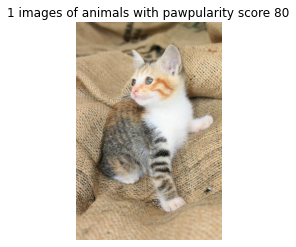

In [ ]:
def pick_image(data, folder, pawpularity, old_index):
  '''Takes the data file. the folder name, the wanted pawpularity score and the 
  index of indexes with the same pawpularity score. It checks if the pawpularity
  score is the same as the score of the image. If it is it returns the image and
  its index in the dataframe ''' 

  # Set an impossible score that can never equal the real one
  score = -1

  while score != pawpularity:

    # Pick random image
      name = random.choice(os.listdir(folder))
      index = data[data['Id']==name.strip('.jpg')].index.item()

      if index not in old_index:        
        score = data['Pawpularity'][index]
        old_index.append(index)
  
  # Load image and convert to RGB from BGR
  img_original = cv2.imread(os.path.join(folder,name))
  im_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
  return im_rgb, index

def pick_random_image(data, folder, amount = None, pawpularity = None):  
  ''' Takes a data set, a folder name to pick the image from. Takes an amount of
  images. It returns and the pawpularity it should return. If the amount and 
  pawpularity are not given in creates a random one. 
  Returns picture(s) of animals with given pawpularity score.
  '''

  # Gives random numbers of none are given
  if amount == None:
    amount = random.randint(1, 4)
  if pawpularity == None:
    pawpularity = random.randint(0, 100)
 
  
  top_list =  []
  old_index = []

  # looks for images
  for _ in range(amount):        
    image, index = pick_image(data, folder, pawpularity, old_index)
    top_list.append(image)
    old_index.append(index)    
    
  # Difference between printing 1 or more images
  if amount == 1:
    plt.imshow(top_list[0])
    plt.title(f'{amount} images of animals with pawpularity score {pawpularity}') 
    plt.axis('off')
  else:
    fig = plt.figure()
        
    for index, image in enumerate(top_list):
      
      ax = fig.add_subplot(2, amount, index + 1)  
      ax.imshow(image)
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)
    fig.suptitle(f'{amount} images of animals with pawpularity score {pawpularity}')

 
  plt.show()

for i in range(1):
  pick_random_image(train_data, 'train', 1)

# Process Tabular Data


This function prepares the tabular data for use later in the Notebook. 

In [ ]:
# # Use np.array to convert the data to an array
tabular = np.array(train_data[['Subject Focus', 'Eyes', 'Face', 'Near', "Action", 'Accessory','Group', 'Collage','Human', 'Occlusion', 'Info', 'Blur']])

# # Add the original dimensions of the image to the tabular data
tabular_IV = np.hstack((np.hstack((tabular, np.array([height]).T)), np.array([width]).T))

# Milestone I

The purpose of this milestone was to build a simple baseline model. The model build in this milestone is convolutional neural network for the task of image regression. Upon evaluation, it became evident the model lacked complexity to achieve better performances. 

## Making The Model

The code below belongs to the first model build for Milestone I. It comprises a simple convolutional neural network. 
The ReLu activation function was used for all layers, with the exception of the last layer. In this layer, no activation function was used because the task at hand is a regression task.

Epoch 1/2
248/248 [==============================] - 19s 15ms/step - loss: 159640.0156 - root_mean_squared_error: 399.5498 - val_loss: 487.0984 - val_root_mean_squared_error: 22.0703
Epoch 2/2
248/248 [==============================] - 3s 14ms/step - loss: 1166.1416 - root_mean_squared_error: 34.1488 - val_loss: 450.1625 - val_root_mean_squared_error: 21.2170


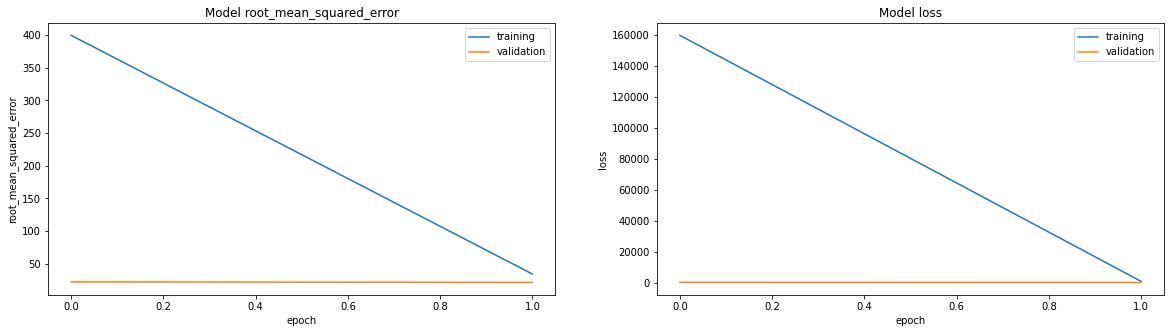

In [ ]:
# Create a sequential model
model = models.Sequential()

# Input layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))

# Add max pooling
model.add(layers.MaxPooling2D((2, 2)))

# Add a flatten layer
model.add(layers.Flatten())

# Add a dense layer
model.add(layers.Dense(512, activation='relu'))

# Add a dropout layer
model.add(tf.keras.layers.Dropout(0.1))

# Add several dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))

# Output layer
model.add(layers.Dense(1, activation=None))

# Use Train_and_evaluate to compile the model and evaluate its performance
train_model = class_train_and_evaluate.Train_and_evaluate(model, 'adam', images, image_labels, epochs = 2)
train_model.train_regular()

# Milestone II

The code below belongs to the model formed for Milestone II. The purpose of this milestone was to expand the model from Milestone I.

The main problem of this model is that it overfits the training data, regardless of a relatively large amount of dropout. 

Epoch 1/2
248/248 [==============================] - 6s 20ms/step - loss: 588.9300 - root_mean_squared_error: 24.2679 - val_loss: 562.7697 - val_root_mean_squared_error: 23.7228
Epoch 2/2
248/248 [==============================] - 4s 15ms/step - loss: 536.1113 - root_mean_squared_error: 23.1541 - val_loss: 457.5492 - val_root_mean_squared_error: 21.3904


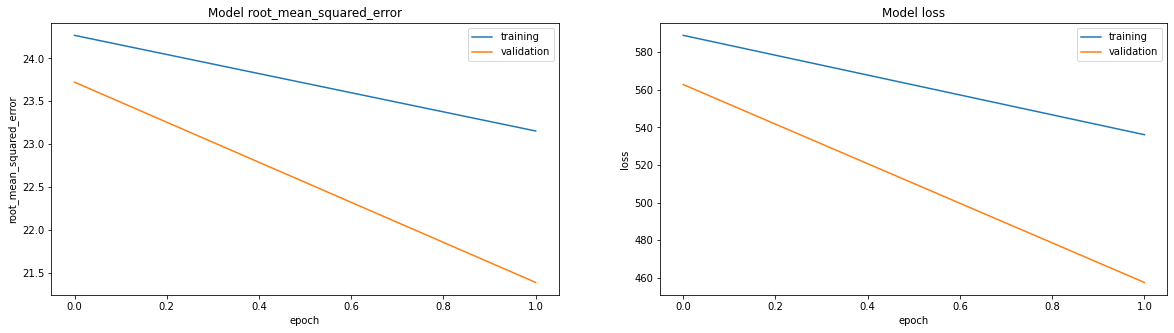

In [ ]:
# Create a sequential model
model=tf.keras.Sequential()

# Input layer
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))

# Add max pooling 
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add a second layer
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add batchnormalization
model.add(layers.BatchNormalization())

# Add a third layer
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

# Add a fourth layer
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

# Add a flatten layer
model.add(tf.keras.layers.Flatten())

# Add several dense layers with dropout
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(512,activation='relu'))

model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(256,activation='relu'))

model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(128,activation='relu'))

# Output layer
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation=None))

# Add preprocessing to normalize the images
preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# Use Train_and_evaluate to compile the model and evaluate its performance
train_model = class_train_and_evaluate.Train_and_evaluate(model, 'adam', images, image_labels, epochs = 2)
train_model.train_regular()

# Milestone III
The code for this milestone corresponds to two different models.

The first model is an extension of the convolutional neural network with L2  regularization for the purpose of reducing overfit. This aim was obtained, yet not succesfully, as the model seems to underfit the data now.

The second model is a convolutional neural network combined with tabular data. A potential problem of this model is the possibility that the tabular data is dense enough for the network to form a prediction, implying that the model will not train its convolutional part until its tabular branch is completely done training. 

### The Convolutional Neural Network

Epoch 1/2
248/248 [==============================] - 5s 17ms/step - loss: 1163.0017 - root_mean_squared_error: 30.7324 - val_loss: 1202.8689 - val_root_mean_squared_error: 33.8526
Epoch 2/2
248/248 [==============================] - 4s 16ms/step - loss: 1024.3062 - root_mean_squared_error: 29.1996 - val_loss: 1121.0846 - val_root_mean_squared_error: 32.8366


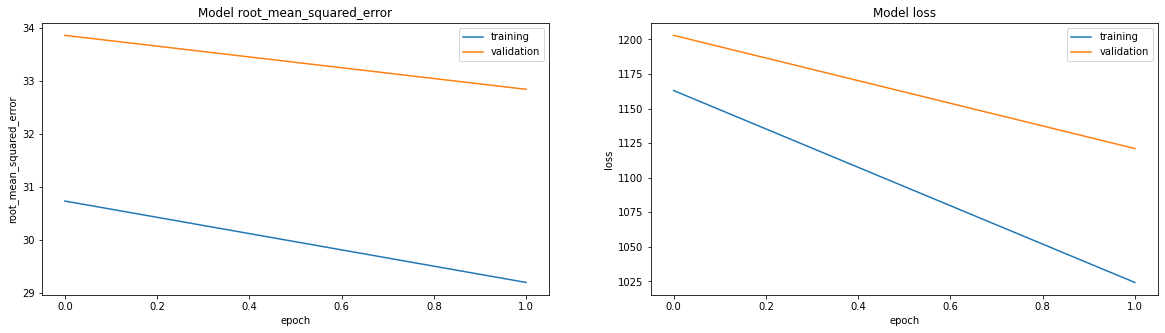

In [ ]:
# Create a sequential model
model=tf.keras.Sequential()

# Input layer
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))

# Add max pooling
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add a dropout layer
model.add(tf.keras.layers.Dropout(0.3))

# Add the second layer
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add batchnormalization
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Add the third layer 
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Add the fourth layer, without dropout
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-4)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

# Add the flatten layer 
model.add(tf.keras.layers.Flatten())

# Add several dense layers with dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-1)))

# Output layer
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(1,activation=None))

# Add preprocessing to normalize the images
preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# Use Train_and_evaluate to compile the model and evaluate its performance
train_model = class_train_and_evaluate.Train_and_evaluate(model, 'adam', images, image_labels, epochs = 2)
train_model.train_regular()

### The Combined Convolutional and Tabular Network
Though it has not been used in any version of the model thus far, a set of tabular data was provided in addition to the image data. Adding this data to the model is a potential way of enhancing the performance of the model. The tabular branch of the neural network was concatenated with the convolutional branch before the output layer in the network.

For the combined convolutional and tabular network the tabular data is transfomed into a numpy array.

#### Making a new model with layers for image and tabular data

Epoch 1/2
248/248 [==============================] - 5s 17ms/step - loss: 564.9188 - root_mean_squared_error: 23.7680 - val_loss: 437.3606 - val_root_mean_squared_error: 20.9132
Epoch 2/2
248/248 [==============================] - 4s 16ms/step - loss: 465.7170 - root_mean_squared_error: 21.5805 - val_loss: 419.6825 - val_root_mean_squared_error: 20.4862


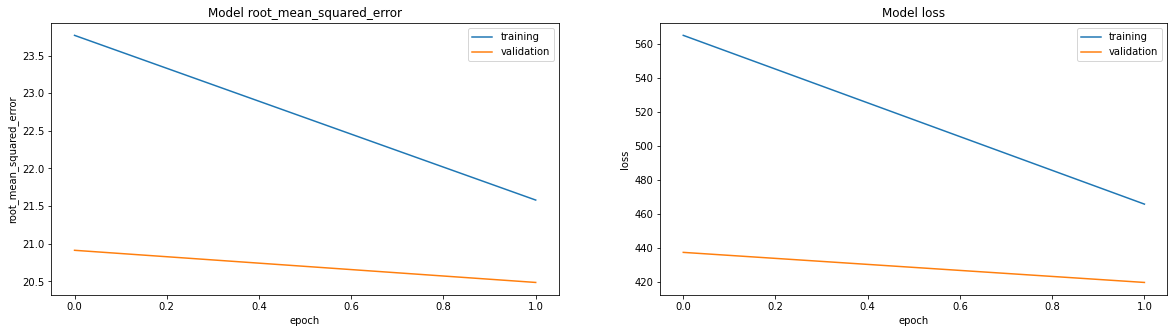

In [ ]:
# Create the convolutional branch of the model for the images 
model_img = tf.keras.Input(shape = images.shape[1:], name = 'IMG')

# Add the first convolutional layer 
model_img_1 = tf.keras.layers.Conv2D(64,(3,3),activation='relu' ,padding='same', name = 'IMG_1')(model_img)

# Add max pooling
model_img_2 = tf.keras.layers.MaxPool2D((2,2))(model_img_1)

# Add the second layer
model_img_3 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(model_img_2)
model_img_4 = tf.keras.layers.MaxPool2D((2,2))(model_img_3)

# Add batchnormalization
model_img_5 = tf.keras.layers.BatchNormalization()(model_img_4)

# Add the third layer
model_img_6 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(model_img_5)
model_img_7 = tf.keras.layers.MaxPool2D((2,2))(model_img_6)
model_img_8 = tf.keras.layers.BatchNormalization()(model_img_7)

# Add dropout before the fourth layer
model_img_9 = tf.keras.layers.Dropout(0.1)(model_img_8)
model_img_10 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same')(model_img_9)
model_img_11 = tf.keras.layers.MaxPool2D((2,2))(model_img_10)
model_img_12 = tf.keras.layers.BatchNormalization()(model_img_11)

# Add the flatten layer
model_img_13 = tf.keras.layers.Flatten()(model_img_12)

# Add dropout before several dense layers
model_img_14 = tf.keras.layers.Dropout(0.4)(model_img_13)
model_img_15 = tf.keras.layers.Dense(512,activation='relu')(model_img_14)

model_img_16 = tf.keras.layers.Dropout(0.4)(model_img_15)
model_img_17 = tf.keras.layers.Dense(256,activation='relu')(model_img_16)

model_img_18 = tf.keras.layers.Dropout(0.4)(model_img_17)
model_img_19 = tf.keras.layers.Dense(128,activation='relu')(model_img_18)

model_img_20 = tf.keras.layers.Dropout(0.4)(model_img_19)

# Create the tabular branch of the model using dense layers
model_tabular = tf.keras.Input(shape = tabular.shape[1:], name = 'model_tabular') 
model_tabular1 = tf.keras.layers.Dense(30, activation='relu', name='model_tabular1')(model_tabular)
model_tabular2 = tf.keras.layers.Dense(50, activation='relu', name='model_tabular2')(model_tabular1)
model_tabular3 = tf.keras.layers.Dense(30, activation='relu', name='model_tabular3')(model_tabular2)
model_tabular4 = tf.keras.layers.Dense(10, activation='relu', name='model_tabular4')(model_tabular3)

# Create the layer to concatenate the branches
model_concat = tf.keras.layers.Concatenate(name = 'connection', axis = 1)([model_tabular4, model_img_20])

# Output layer
model_fin = tf.keras.layers.Dense(1, activation = 'linear', name = 'finished' )(model_concat)

# Combine the branches model image and tabular model in the model
model = tf.keras.Model(inputs = [model_img, model_tabular], outputs = model_fin)

# Add preprocessing to normalize the images
preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# Use Train_and_evaluate to compile the model and evaluate its performance
train_model = class_train_and_evaluate.Train_and_evaluate(model, 'adam', images, image_labels, epochs = 2)
train_model.train_combined(tabular)

# Milestone IV

In milestone IV we looked at different optimizers, made changes to our tabular model, we used data augmentations and we used k-fold to look for the optimal model. 

## Optimizers
We will run the two basic models from Milestone II with two different optimizers to evaluate how these optimizers affect the results.

Epoch 1/2
248/248 [==============================] - 5s 16ms/step - loss: 924.8955 - root_mean_squared_error: 28.3498 - val_loss: 1341.6605 - val_root_mean_squared_error: 36.5118
Epoch 2/2
248/248 [==============================] - 4s 15ms/step - loss: 869.8515 - root_mean_squared_error: 27.7641 - val_loss: 1332.8890 - val_root_mean_squared_error: 36.3461


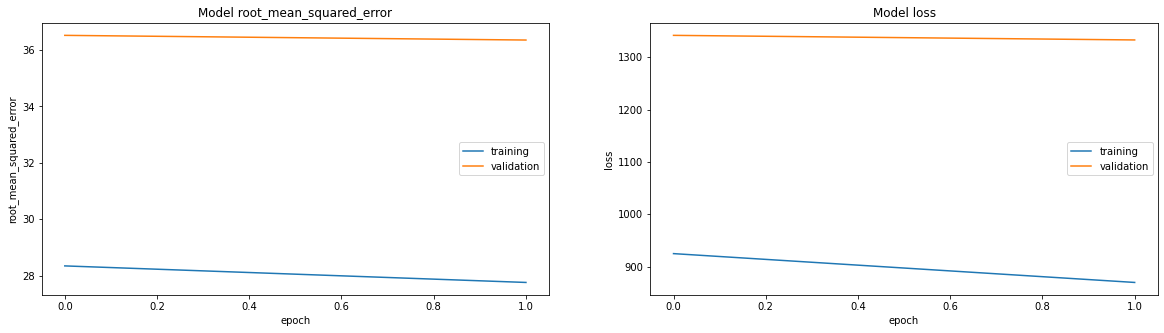

In [ ]:
# Create a sequential model
model=tf.keras.Sequential()

# Input layer
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))

# Add max pooling
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add a dropout layer
model.add(tf.keras.layers.Dropout(0.3))

# Add the second layer
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add batchnormalization
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Add the third layer 
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Add the fourth layer, without dropout
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-4)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

# Add the flatten layer 
model.add(tf.keras.layers.Flatten())

# Add several dense layers with dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-1)))

# Output layer
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(1,activation=None))

# Add preprocessing to normalize the images
preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# Use Train_and_evaluate to compile the model and evaluate its performance
train_model = class_train_and_evaluate.Train_and_evaluate(model, 'SGD', images, image_labels, epochs = 2)
train_model.train_regular()

Epoch 1/2
248/248 [==============================] - 6s 18ms/step - loss: 1037.2354 - root_mean_squared_error: 30.2916 - val_loss: 714.6218 - val_root_mean_squared_error: 25.8067
Epoch 2/2
248/248 [==============================] - 4s 17ms/step - loss: 858.5492 - root_mean_squared_error: 27.2344 - val_loss: 771.8780 - val_root_mean_squared_error: 27.0945


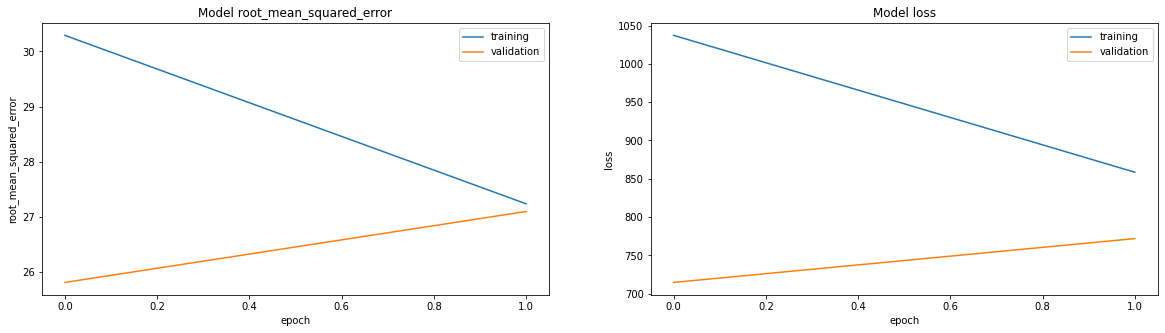

In [ ]:
# Create a sequential model
model=tf.keras.Sequential()

# Input layer
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))

# Add max pooling
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add a dropout layer
model.add(tf.keras.layers.Dropout(0.3))

# Add the second layer
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add batchnormalization
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Add the third layer 
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Add the fourth layer, without dropout
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-4)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

# Add the flatten layer 
model.add(tf.keras.layers.Flatten())

# Add several dense layers with dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-1)))

# Output layer
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(1,activation=None))

# Add preprocessing to normalize the images
preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# Use Train_and_evaluate to compile the model and evaluate its performance
train_model = class_train_and_evaluate.Train_and_evaluate(model, 'FTRL', images, image_labels, epochs = 2)
train_model.train_regular()

## Network with augmentation
The number of samples to train the model (7929) is rather small for an image regression task. For this reason, data augmentation was used to artificially increase the data and avoid overfitting.

Epoch 1/2
248/248 [==============================] - 14s 50ms/step - loss: 1142.7749 - root_mean_squared_error: 30.2442 - val_loss: 1377.2485 - val_root_mean_squared_error: 36.7350
Epoch 2/2
248/248 [==============================] - 11s 45ms/step - loss: 1036.4910 - root_mean_squared_error: 29.1831 - val_loss: 1378.3385 - val_root_mean_squared_error: 36.6879


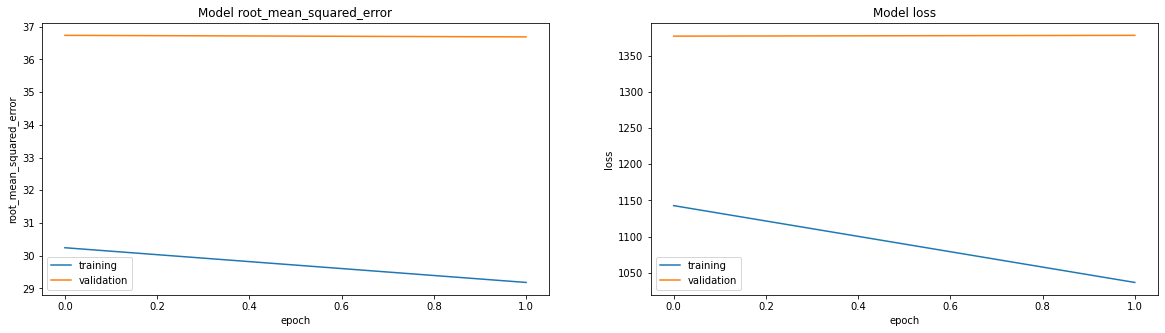

62/62 [==============================] - 1s 8ms/step - loss: 1378.3386 - root_mean_squared_error: 36.6879
Epoch 1/2
248/248 [==============================] - 13s 47ms/step - loss: 1045.0590 - root_mean_squared_error: 29.5194 - val_loss: 1390.3933 - val_root_mean_squared_error: 36.6605
Epoch 2/2
248/248 [==============================] - 11s 46ms/step - loss: 1004.5518 - root_mean_squared_error: 29.0193 - val_loss: 1294.0647 - val_root_mean_squared_error: 35.3849


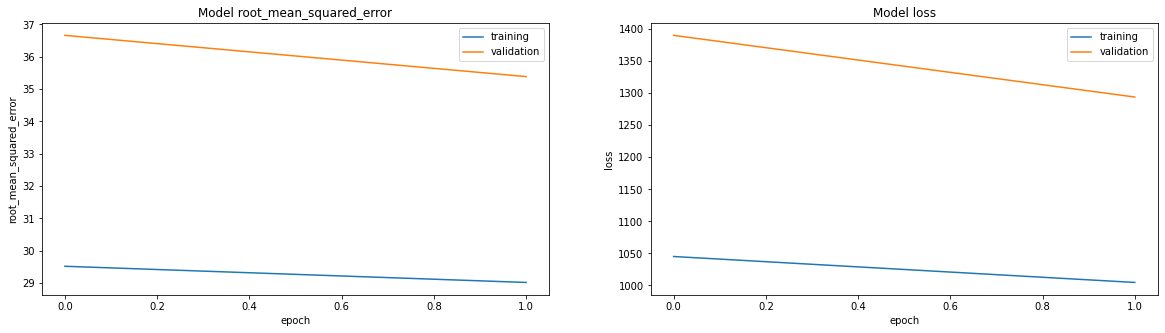

62/62 [==============================] - 0s 7ms/step - loss: 1294.0646 - root_mean_squared_error: 35.3849
The mean score is 36.03643226623535


In [ ]:
# Create a sequential model
model=tf.keras.Sequential()

# Add the first convolutional layer
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))

# Add maxpooling
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add dropout 
model.add(tf.keras.layers.Dropout(0.3))

# Add the second convolutional layer
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add batchnormalization
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Add the third convolutional layer
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Add the fourth convolutional layer without dropout, but with L2 regularization
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-4)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

# Add a flatten layer
model.add(tf.keras.layers.Flatten())

# Add several dense layers with dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))

model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))

# Implement L2 regularization in the second to last dense layer
model.add(tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-1)))
model.add(tf.keras.layers.Dropout(0.7))

# Output layer 
model.add(tf.keras.layers.Dense(1,activation=None))

# Add preprocessing to normalize the data 
preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# Add augment to apply data augmentation
augment = {'rotation_range' : 30 , 'vertical_flip' : True, 'width_shift_range' : 0.25, 'height_shift_range' : 0.25}

# Use Train_and_evaluate to compile the model and evaluate its performance
train_model = class_train_and_evaluate.Train_and_evaluate(model, 'adam', images, image_labels, epochs = 2)
train_model.train_kfold(2, preprocess, augment)

## Altering the network structure

To reduce the need for a heavy amount of dropout in the earlier model, the ReLu activation function was modified. Instead, the Leaky ReLu activation function was used in all layers. 
To increase the complexity of the model, fully connected convolutional layers were added with the purpose of allowing the model to extract more complex features from the dataset.
Augmentation was also implemented in this deeper network.

Epoch 1/2
248/248 [==============================] - 18s 62ms/step - loss: 792.5539 - root_mean_squared_error: 24.8772 - val_loss: 990.7635 - val_root_mean_squared_error: 23.3871
Epoch 2/2
248/248 [==============================] - 14s 58ms/step - loss: 665.0696 - root_mean_squared_error: 23.4205 - val_loss: 639.1801 - val_root_mean_squared_error: 22.9440


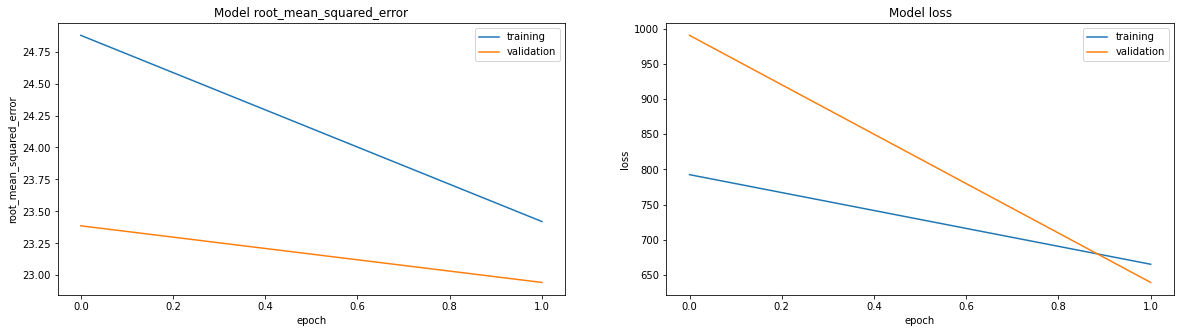

Epoch 1/2
248/248 [==============================] - 16s 59ms/step - loss: 673.6741 - root_mean_squared_error: 23.3395 - val_loss: 902.2090 - val_root_mean_squared_error: 21.6640
Epoch 2/2
248/248 [==============================] - 15s 58ms/step - loss: 629.2467 - root_mean_squared_error: 22.8935 - val_loss: 1132.8895 - val_root_mean_squared_error: 24.8198


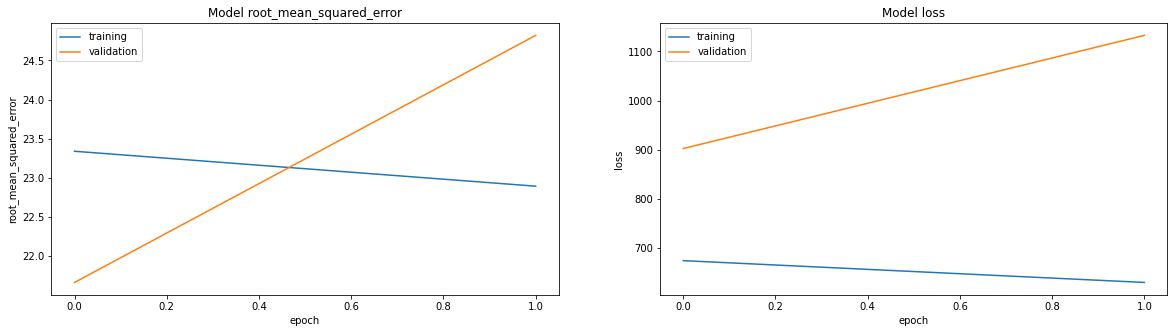

The mean score is nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Create a sequential model
model=tf.keras.Sequential()

# Add the first fully connected convolutional layer
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='leaky_relu',input_shape=(64,64,3),padding='same'))
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='leaky_relu',padding='same'))

# Add max pooling
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add dropout
model.add(tf.keras.layers.Dropout(0.2))

# Add the second group of fully connected convolutional layers with max pooling
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='leaky_relu',padding='same'))
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='leaky_relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

# Add batchnormalization
model.add(layers.BatchNormalization())

# Add dropout 
model.add(tf.keras.layers.Dropout(0.2))

# Add the third group of fully connected convolutional layers
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='leaky_relu',padding='same'))
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='leaky_relu',padding='same'))
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='leaky_relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))

# Add the fourth group of fully connected convolutional layers, without dropout, yet with L2 regularization
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='leaky_relu',padding='same'))
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='leaky_relu',padding='same'))
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='leaky_relu',padding='same',activity_regularizer=regularizers.l2(1e-4)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

# Add a flatten layer
model.add(tf.keras.layers.Flatten())

# Implement L2 regularizartion and dropout
model.add(tf.keras.layers.Dense(256, activation='leaky_relu', activity_regularizer=regularizers.l2(1e-1)))
model.add(tf.keras.layers.Dropout(0.5))

# Add several dense layers with dropout
model.add(tf.keras.layers.Dense(128,activation='leaky_relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(64,activation='leaky_relu'))
model.add(tf.keras.layers.Dropout(0.5))

# Output layer
model.add(tf.keras.layers.Dense(1,activation=None))

# Add preprocessing to normalize the data
preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# Add augment to apply data augmentation
augment = {'rotation_range' : 30, 'vertical_flip' : True, 'width_shift_range' : 8, 'height_shift_range' : 8}

# Use Train_and_evaluate to compile the model and evaluate its performance
train_model = class_train_and_evaluate.Train_and_evaluate(model, 'adam', images, image_labels, epochs = 2)
train_model.train_kfold(2, preprocess, augment)

## Combined tabular and image model
This model combines the tabular and image models after flattening the convolution data. This way the convolution data will be more intertwined because of the dense layers.

This should result in a more even distribution of what data the model deems important. The main problem of this model is that it seems to generate the average score as the output, regardless of its input. 

Also the original size of the image is added to the tabular data.

Epoch 1/2
248/248 [==============================] - 6s 18ms/step - loss: 1074.5658 - root_mean_squared_error: 29.1721 - val_loss: 955.4804 - val_root_mean_squared_error: 26.4935
Epoch 2/2
248/248 [==============================] - 4s 17ms/step - loss: 816.0348 - root_mean_squared_error: 26.8323 - val_loss: 715.8866 - val_root_mean_squared_error: 24.6286


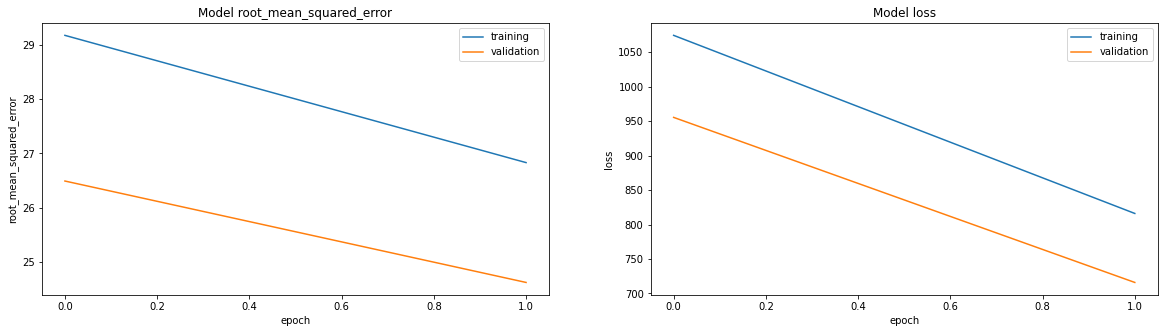

In [ ]:
# Create the convolutional branch of the model for the images 
model_img = tf.keras.Input(shape = images.shape[1:])

# Add the first convolutional layer
model_img_1 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same')(model_img)

# Add max pooling
model_img_2 = tf.keras.layers.MaxPool2D((2,2))(model_img_1)

# Add dropout 
model_img_3 = tf.keras.layers.Dropout(0.3)(model_img_2)

# Add the second convolutional layer 
model_img_4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(model_img_3)
model_img_5 = tf.keras.layers.MaxPool2D((2,2))(model_img_4)

# Add batchnormalization
model_img_6 = layers.BatchNormalization()(model_img_5)
model_img_7 = tf.keras.layers.Dropout(0.3)(model_img_6)

# Add the third convolutional layer
model_img_8 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(model_img_7)
model_img_9 = tf.keras.layers.MaxPool2D((2,2))(model_img_8)
model_img_10 = layers.BatchNormalization()(model_img_9)
model_img_11 = tf.keras.layers.Dropout(0.3)(model_img_10)

# Add the fourth convolutional layer
model_img_12 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-2))(model_img_11)
model_img_13 = tf.keras.layers.MaxPool2D((2,2))(model_img_12)
model_img_14 = layers.BatchNormalization()(model_img_13)

# Add the flatten layer
model_img_15 = tf.keras.layers.Flatten()(model_img_14)

# Create the tabular branch of the model using dense layers
model_tabular = tf.keras.Input(shape = tabular_IV.shape[1:], name = 'tabular') 
model_tabular1 = tf.keras.layers.Dense(30, activation='relu', name='tabular1')(model_tabular)
model_tabular2 = tf.keras.layers.Dense(50, activation='relu', name='tabular2')(model_tabular1)
model_tabular3 = tf.keras.layers.Dense(30, activation='relu', name='tabular3')(model_tabular2)
model_tabular4 = tf.keras.layers.Dense(10, activation='relu', name='tabular4')(model_tabular3)

# Create the layer to concatenate the branches
model_concat = tf.keras.layers.Concatenate(name = 'connection', axis = 1)([model_tabular4, model_img_15])

# Add several more dense layers with dropout
model_img_16 = tf.keras.layers.Dense(256, activation='relu')(model_concat)
model_img_17 = tf.keras.layers.Dropout(0.7)(model_img_16)

model_img_18 = tf.keras.layers.Dense(128,activation='relu')(model_img_17)
model_img_19 = tf.keras.layers.Dropout(0.7)(model_img_18)

model_img_20 = tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-2))(model_img_19)
model_img_21 = tf.keras.layers.Dropout(0.6)(model_img_20)

# Output layer
model_fin = tf.keras.layers.Dense(1, activation = 'linear', name = 'finished' )(model_img_21)

# Combine the branches model image and tabular model in the model 
model = tf.keras.Model(inputs = [model_img, model_tabular], outputs = model_fin)

# Add preprocessing to normalize the images
preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# Use Train_and_evaluate to compile the model and evaluate its performance
train_model = class_train_and_evaluate.Train_and_evaluate(model, 'adam', images, image_labels, epochs = 2)
train_model.train_combined(tabular_IV)

### Problem with tabular data

We can see below that the addition of tabular data does not help our model. The model just picks a single value and gives this score to all the images.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


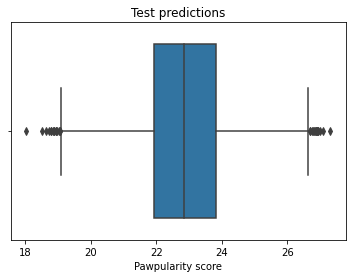

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


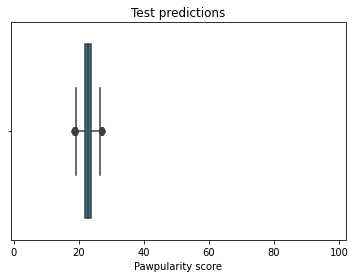

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


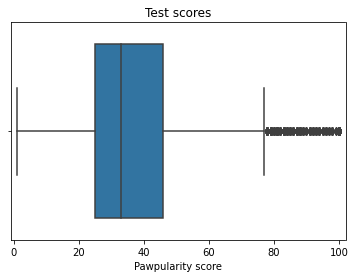

In [ ]:
# calculate the predictions
predictions = model.predict([images, tabular_IV])

# create a boxplot using these predictions
sns.boxplot(predictions)
plt.title('Test predictions')
plt.xlabel("Pawpularity score")
plt.show()

# create a zoomed in boxplot with the same predictions
pred_plot = sns.boxplot(predictions)
pred_plot.set(xlim=(-1, 102))
plt.title('Test predictions')
plt.xlabel("Pawpularity score")
plt.show()

# create a boxplot of all images
data_plot = sns.boxplot(image_labels)
data_plot.set(xlim=(-1, 102))
plt.title('Test scores')
plt.xlabel("Pawpularity score")
plt.show()